<a href="https://colab.research.google.com/github/a123700/Leo/blob/master/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cycle Generative Adversarial Network

### Setup

In [1]:
api_token = {"username":"srhgccc","key":"41c36ccc1ee7bc07f70e459ccbf7df7c"}
import json
import zipfile
import os
 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')

In [2]:
!kaggle datasets download -d balraj98/summer2winter-yosemite

 96% 121M/126M [00:00<00:00, 152MB/s] 
100% 126M/126M [00:00<00:00, 136MB/s]


In [3]:
!unzip summer2winter-yosemite.zip

Archive:  summer2winter-yosemite.zip
  inflating: metadata.csv            
  inflating: testA/2010-09-07 12_23_20.jpg  
  inflating: testA/2010-10-05 13_45_11.jpg  
  inflating: testA/2010-10-05 19_08_31.jpg  
  inflating: testA/2011-05-23 17_46_40.jpg  
  inflating: testA/2011-05-26 15_06_01.jpg  
  inflating: testA/2011-05-28 15_13_21.jpg  
  inflating: testA/2011-05-29 10_20_21.jpg  
  inflating: testA/2011-05-29 13_29_21.jpg  
  inflating: testA/2011-06-03 03_36_41.jpg  
  inflating: testA/2011-06-03 15_29_50.jpg  
  inflating: testA/2011-06-03 21_27_20.jpg  
  inflating: testA/2011-06-04 19_38_11.jpg  
  inflating: testA/2011-06-09 12_02_20.jpg  
  inflating: testA/2011-06-14 23_29_30.jpg  
  inflating: testA/2011-06-20 08_47_21.jpg  
  inflating: testA/2011-06-26 19_33_40.jpg  
  inflating: testA/2011-06-27 23_17_41.jpg  
  inflating: testA/2011-06-29 20_57_51.jpg  
  inflating: testA/2011-07-01 00_00_00.jpg  
  inflating: testA/2011-07-02 10_57_31.jpg  
  inflating: testA/2011-0

In [4]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-lduf_td7
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-lduf_td7
  Resolved https://github.com/tensorflow/docs to commit ed4a55140445dfd33ed8ac5c9b21b9fa86ec9b44
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184468 sha256=b40e8688936ca7ca42bc5dec219e03b2a6d4cbc5461102c8ed6d0b0bda22d0f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-5shh03w8/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs


In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

import matplotlib.pyplot as plt
import cv2
import concurrent.futures

import warnings
warnings.filterwarnings('ignore')

import keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tqdm import tqdm

from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization, Activation
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from IPython.display import clear_output

### Load and prepare the dataset

In [6]:
train_A_paths = glob.glob('trainA/*.jpg')
train_B_paths = glob.glob('trainB/*.jpg')
print(len(train_A_paths))
print(len(train_B_paths))

test_A_paths = glob.glob('testA/*.jpg')
test_B_paths = glob.glob('testB/*.jpg')
print(len(train_A_paths))
print(len(train_B_paths))

1231
962
1231
962


In [7]:
def read_img(image):
    img = tf.keras.preprocessing.image.load_img(image, color_mode='rgb', target_size=(img_size, img_size))
    return img
def prepare_dataset(namelist):
    start = time.time()
    imgs = []
    with concurrent.futures.ThreadPoolExecutor(max_workers = 16) as executor:
        i = 0
        for value in executor.map(read_img, namelist):
            i+=1
            print("\rFetching: [{}/{}]".format(i, len(namelist)), end="", flush=True)
            imgs.append(value)
        imgs = np.stack(imgs)
        imgs = tf.convert_to_tensor(imgs)
    print("\nExecution time: ",round(time.time() - start), "s")
    return imgs

In [8]:
img_size = 64
channels = 3

images=prepare_dataset(train_A_paths)
images_trans=prepare_dataset(train_B_paths)

images_test=prepare_dataset(test_A_paths)
images_trans_test=prepare_dataset(test_B_paths)

Fetching: [1231/1231]
Execution time:  9 s
Fetching: [962/962]
Execution time:  6 s
Fetching: [309/309]
Execution time:  2 s
Fetching: [238/238]
Execution time:  1 s


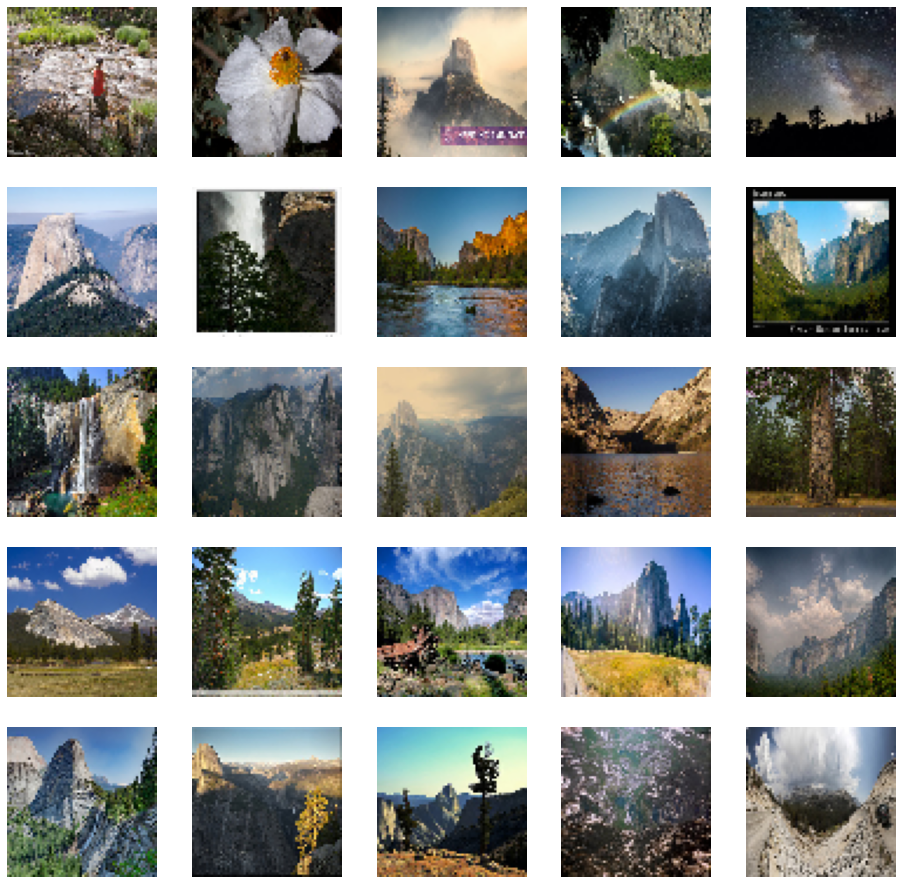

In [9]:
_,ax = plt.subplots(5,5, figsize = (16, 16)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

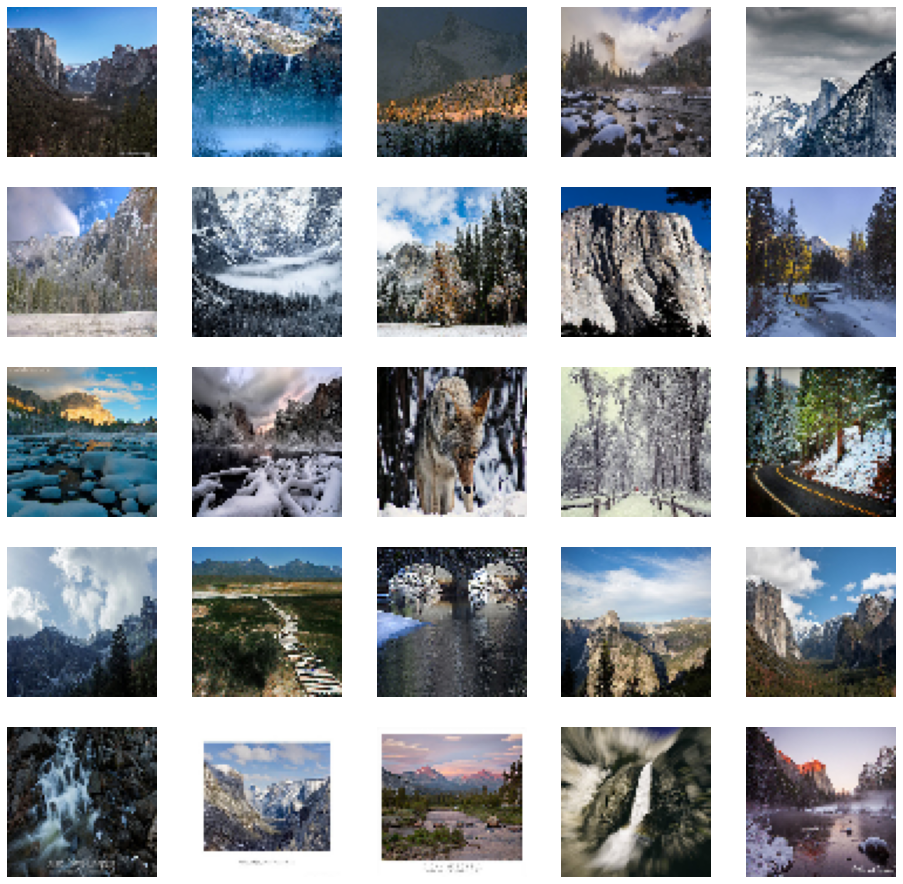

In [10]:
_,ax = plt.subplots(5,5, figsize = (16, 16)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images_trans[5*i+j])
        ax[i,j].axis('off')

In [11]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

train_images = images.reshape(-1, img_size, img_size, channels).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

train_trans_images = images_trans.reshape(-1, img_size, img_size, channels).astype('float32')
train_trans_images = (train_trans_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

test_images = images_test.reshape(-1, img_size, img_size, channels).astype('float32')
test_images = (test_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

test_trans_images = images_trans_test.reshape(-1, img_size, img_size, channels).astype('float32')
test_trans_images = (train_trans_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

## Hyperparameter

In [12]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

img_shape = (img_size, img_size, channels)

In [13]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
train_trans_dataset = tf.data.Dataset.from_tensor_slices(train_trans_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

## Create the models


### The Generator

In [14]:
def make_generator_model():
    input = Input(shape=img_shape)
    x = Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(input)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Reshape((img_size//8, img_size//8, -1))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same",
                   use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same",
               use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64*1, kernel_size=3, strides=1, padding="same",
                   use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x,training=1)
    x = Conv2D(64*1, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*1, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(channels, kernel_size=3, strides=1, padding="same", activation="tanh",
               use_bias=False,)(x)

    model = Model(input, x)
    model.summary()
    return model

Use the (as yet untrained) generator to create an image.

In [56]:
generator = make_generator_model()

example_image = np.reshape(test_images[:16], (-1, img_size, img_size, channels))
generated_image = generator(example_image, training=False)
cycle_image = generator(generated_image, training=False)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_62 (Conv2D)          (None, 32, 32, 64)        3072      
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_63 (Conv2D)          (None, 16, 16, 128)       131072    
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_64 (Conv2D)          (None, 8, 8, 256)         524288    
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 8, 8, 256)         0   

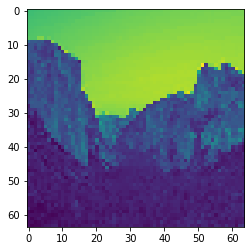

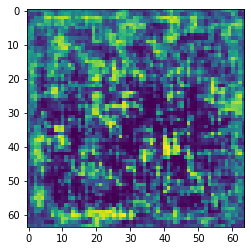

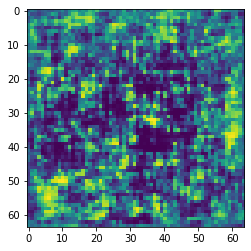

In [58]:
plt.imshow(example_image[0, :, :, 0])
plt.show()

plt.imshow(generated_image[0, :, :, 0])
plt.show()

plt.imshow(cycle_image[0, :, :, 0])
plt.show()

### The Discriminator


In [17]:
def make_discriminator_model():
    input = Input(shape=img_shape)
    x = Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(input)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(1, kernel_size=1, strides=1, padding="same", use_bias=False)(x)
    x = Flatten()(x)

    input1 = Input(shape=img_shape)
    y = Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(input1)
    y = LeakyReLU(0.2)(y)
    y = Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)(y)
    y = LeakyReLU(0.2)(y)
    y = Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(y)
    y = LeakyReLU(0.2)(y)
    y = Conv2D(256, kernel_size=3, strides=1, padding="same", use_bias=False)(y)
    y = LeakyReLU(0.2)(y)
    y = Conv2D(256, kernel_size=3, strides=1, padding="same", use_bias=False)(y)
    y = LeakyReLU(0.2)(y)
    y = Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False)(y)
    y = LeakyReLU(0.2)(y)
    y = Conv2D(1, kernel_size=1, strides=1, padding="same", use_bias=False)(y)
    y = Flatten()(y)
    
    z = layers.Dot(axes=1)([x, y])
    z = Dense(units=1, activation='sigmoid')(z) 
    
    model = Model([input, input1], z)
    model.summary()
    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [18]:
discriminator = make_discriminator_model()
target_image = np.reshape(train_trans_images[0], (-1, img_size, img_size, channels))
generated_image = np.reshape(generated_image[0], (-1, img_size, img_size, channels))

decision = discriminator([generated_image, target_image])
print(decision)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 32, 32, 64)   3072        ['input_2[0][0]']                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 32, 32, 64)   3072        ['input_3[0][0]']                
                                                                                            

## Define the loss and optimizers


In [19]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss


In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
def cycle_loss(A2B, B2A):
  loss_fn = tf.keras.losses.MeanSquaredError()
  return loss_fn(A2B, B2A)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [23]:
A2B_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
B2A_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Define the training loop


In [24]:
EPOCHS = 200
A2B_gen = make_generator_model()
B2A_gen = make_generator_model()

cycle_input = Input(shape=img_shape)
A2B = A2B_gen(cycle_input)
B2A = B2A_gen(A2B)
cycle_model = Model(cycle_input, B2A)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 64)        3072      
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 16, 16, 128)       131072    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 8, 8, 256)         524288    
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 8, 8, 256)         0   

In [25]:
@tf.function
def train_step(images, target_images, gp_weight=10.0):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as cycle_tape:
      A2B_images = A2B_gen(images, training=True)
      B2A_images = B2A_gen(A2B_images, training=True)

      real_output = discriminator([images, images], training=True)
      fake_output = discriminator([images, B2A_images], training=True)

      gen_loss = generator_loss(fake_output)
      cycled_loss = cycle_loss(images, B2A_images)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, A2B_gen.trainable_variables)
    gradients_of_cycle_A2B = cycle_tape.gradient(cycled_loss, cycle_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    A2B_generator_optimizer.apply_gradients(zip(gradients_of_generator, A2B_gen.trainable_variables))
    B2A_generator_optimizer.apply_gradients(zip(gradients_of_cycle_A2B, cycle_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [26]:
def train(dataset, target_dataset, epochs):
  seed = example_image
  for epoch in range(epochs):
    start = time.time()

    for image_batch, target_batch in tf.data.Dataset.zip((dataset, target_dataset)):
      train_step(image_batch, target_batch)

    # Produce images for the GIF as you go
    clear_output(wait=True)
    generate_and_save_images(A2B_gen,
                             epoch + 1,
                             seed)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, round(time.time()-start)))

  # Generate after the final epoch
  clear_output(wait=True)
  generate_and_save_images(A2B_gen,
                           epochs,
                           seed)

**Generate and save images**


In [33]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  predictions = (predictions * 127.5 + 127.5)

  fig = plt.figure(figsize=(16, 16))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model

In [ ]:
train(train_dataset, train_trans_dataset, EPOCHS)

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)